In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import fetch_covtype
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
import xgboost as xgb

In [41]:
from botorch.utils.sampling import draw_sobol_samples
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import qExpectedImprovement
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.optim import optimize_acqf

✅ Start with initial samples → explore space  
✅ Build GP surrogate model  
✅ Use acquisition function (qEI) to select new batch  
✅ Evaluate batch → update model  
✅ Repeat → the GP gets better over time → faster convergence  

In [20]:
#data = fetch_covtype()
data = fetch_california_housing()
X = data.data
y = data.target

In [22]:
df = pd.DataFrame(X, columns=data.feature_names)
df['MedHouseVal'] = y
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
def train_evaluate(params):
    params = {
        'learning_rate': float(params[0]),
        'max_depth': int(params[1]),
        'min_child_weight': float(params[2]),
        'subsample': float(params[3]),
        'colsample_bytree': float(params[4]),
        'gamma': float(params[5]),
        'lambda': float(params[6]),
        'alpha': float(params[7]),
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'verbosity': 0
    }
    
    # Train model
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = model.predict(X_val)
    # For example, use negative MSE as objective to maximize
    score = -mean_squared_error(y_val, y_pred)
    return score

In [28]:
# Define bounds for each hyperparameter
bounds = torch.tensor([
    [0.01, 0.3],    # learning_rate
    [3, 10],        # max_depth
    [1, 10],        # min_child_weight
    [0.5, 1.0],     # subsample
    [0.5, 1.0],     # colsample_bytree
    [0, 5],         # gamma
    [0, 5],         # lambda
    [0, 5]          # alpha
], dtype=torch.double).T  # shape (2, d)

# Number of parameters
dim = bounds.shape[0]


In [32]:
# 2️⃣ Generate initial samples:
n_initial = 20

train_x = draw_sobol_samples(bounds=bounds, n=n_initial, q=1).squeeze(-2)

# 3️⃣ Evaluate objective:
train_obj = torch.tensor([train_evaluate(x) for x in train_x], dtype=torch.double).unsqueeze(-1)

In [ ]:
# Build GP model
model = SingleTaskGP(train_x, train_obj)

# Define Marginal Log-Likelihood (objective for GP training)
mll = ExactMarginalLogLikelihood(model.likelihood, model)

# Fit the GP model to current data
fit_gpytorch_mll(mll)

/home/mjoudy/miniconda3/envs/bbo_env/lib/python3.10/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): LogNormalPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): LogNormalPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): RBFKernel(
      (lengthscale_prior): LogNormalPrior()
      (raw_lengthscale_constraint): GreaterThan(2.500E-02)
    )
    (outcome_transform): Standardize()
  )
)

In [ ]:
sampler = SobolQMCNormalSampler(sample_shape=torch.Size([500]))

# Define acquisition function
qEI = qExpectedImprovement(
    model=model, 
    best_f=train_obj.max(),
    sampler=sampler
)

/home/mjoudy/miniconda3/envs/bbo_env/lib/python3.10/site-packages/botorch/acquisition/monte_carlo.py:396: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


In [ ]:
# Batch size — how many new points to evaluate per iteration
batch_size = 5

# Optimize acquisition function
candidates, _ = optimize_acqf(
    acq_function=qEI,
    bounds=bounds,
    q=batch_size,
    num_restarts=10,
    raw_samples=100
)


In [42]:
# Evaluate new candidates
new_obj = torch.tensor([train_evaluate(x) for x in candidates], dtype=torch.double).unsqueeze(-1)

# Update training data
train_x = torch.cat([train_x, candidates], dim=0)
train_obj = torch.cat([train_obj, new_obj], dim=0)

# Refit GP model on updated data
model = SingleTaskGP(train_x, train_obj)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)


/home/mjoudy/miniconda3/envs/bbo_env/lib/python3.10/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): LogNormalPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): LogNormalPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): RBFKernel(
      (lengthscale_prior): LogNormalPrior()
      (raw_lengthscale_constraint): GreaterThan(2.500E-02)
    )
    (outcome_transform): Standardize()
  )
)

In [45]:
n_iterations = 10
batch_size = 5
best_values = []

for iteration in range(n_iterations):
    print(f"\n=== Iteration {iteration + 1} ===")
    
    # Define acquisition function
    qEI = qExpectedImprovement(
        model=model,
        best_f=train_obj.max(),
        sampler=SobolQMCNormalSampler(sample_shape=torch.Size([500]))

    )
    
    # Optimize acquisition function
    candidates, _ = optimize_acqf(
        acq_function=qEI,
        bounds=bounds,
        q=batch_size,
        num_restarts=10,
        raw_samples=100
    )
    
    # Evaluate new candidates
    new_obj = torch.tensor([train_evaluate(x) for x in candidates], dtype=torch.double).unsqueeze(-1)
    
    # Update training data
    train_x = torch.cat([train_x, candidates], dim=0)
    train_obj = torch.cat([train_obj, new_obj], dim=0)
    
    # Refit model
    model = SingleTaskGP(train_x, train_obj)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    
    # Print current best R²
    best_values.append(train_obj.max().item())
    print(f"Current best R²: {train_obj.max().item():.4f}")



=== Iteration 1 ===


/home/mjoudy/miniconda3/envs/bbo_env/lib/python3.10/site-packages/botorch/acquisition/monte_carlo.py:396: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mjoudy/miniconda3/envs/bbo_env/lib/python3.10/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


Current best R²: -0.1930

=== Iteration 2 ===


/home/mjoudy/miniconda3/envs/bbo_env/lib/python3.10/site-packages/botorch/acquisition/monte_carlo.py:396: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mjoudy/miniconda3/envs/bbo_env/lib/python3.10/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


Current best R²: -0.1930

=== Iteration 3 ===


/home/mjoudy/miniconda3/envs/bbo_env/lib/python3.10/site-packages/botorch/acquisition/monte_carlo.py:396: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mjoudy/miniconda3/envs/bbo_env/lib/python3.10/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


Current best R²: -0.1930

=== Iteration 4 ===


/home/mjoudy/miniconda3/envs/bbo_env/lib/python3.10/site-packages/botorch/acquisition/monte_carlo.py:396: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mjoudy/miniconda3/envs/bbo_env/lib/python3.10/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


Current best R²: -0.1930

=== Iteration 5 ===


/home/mjoudy/miniconda3/envs/bbo_env/lib/python3.10/site-packages/botorch/acquisition/monte_carlo.py:396: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mjoudy/miniconda3/envs/bbo_env/lib/python3.10/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


Current best R²: -0.1930

=== Iteration 6 ===


/home/mjoudy/miniconda3/envs/bbo_env/lib/python3.10/site-packages/botorch/acquisition/monte_carlo.py:396: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mjoudy/miniconda3/envs/bbo_env/lib/python3.10/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


Current best R²: -0.1930

=== Iteration 7 ===


/home/mjoudy/miniconda3/envs/bbo_env/lib/python3.10/site-packages/botorch/acquisition/monte_carlo.py:396: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mjoudy/miniconda3/envs/bbo_env/lib/python3.10/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


Current best R²: -0.1930

=== Iteration 8 ===


/home/mjoudy/miniconda3/envs/bbo_env/lib/python3.10/site-packages/botorch/acquisition/monte_carlo.py:396: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mjoudy/miniconda3/envs/bbo_env/lib/python3.10/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


Current best R²: -0.1930

=== Iteration 9 ===


/home/mjoudy/miniconda3/envs/bbo_env/lib/python3.10/site-packages/botorch/acquisition/monte_carlo.py:396: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mjoudy/miniconda3/envs/bbo_env/lib/python3.10/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


Current best R²: -0.1930

=== Iteration 10 ===


/home/mjoudy/miniconda3/envs/bbo_env/lib/python3.10/site-packages/botorch/acquisition/monte_carlo.py:396: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/home/mjoudy/miniconda3/envs/bbo_env/lib/python3.10/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


Current best R²: -0.1930


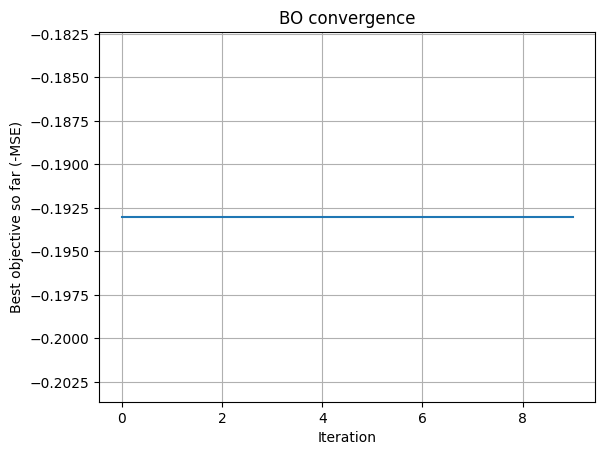

In [48]:
# Plot convergence
plt.plot(best_values)
plt.xlabel('Iteration')
plt.ylabel('Best objective so far (-MSE)')
plt.title('BO convergence')
plt.grid()
plt.show()


In [52]:
print(train_obj)

tensor([[-0.2309],
        [-0.2652],
        [-0.2067],
        [-0.2531],
        [-0.3168],
        [-0.2475],
        [-0.2235],
        [-0.2917],
        [-0.2503],
        [-0.2220],
        [-0.2213],
        [-0.3057],
        [-0.2604],
        [-0.2637],
        [-0.2466],
        [-0.2640],
        [-0.2358],
        [-0.2743],
        [-0.2443],
        [-0.3247],
        [-0.2127],
        [-0.2065],
        [-0.2794],
        [-0.2341],
        [-0.2525],
        [-0.2097],
        [-0.4424],
        [-0.2481],
        [-0.2094],
        [-0.2092],
        [-0.2158],
        [-0.2186],
        [-0.2105],
        [-0.2034],
        [-0.2468],
        [-0.1980],
        [-0.2957],
        [-0.2150],
        [-0.3276],
        [-0.2034],
        [-0.2686],
        [-0.2622],
        [-0.5277],
        [-0.2476],
        [-0.2014],
        [-0.2240],
        [-0.2704],
        [-0.2388],
        [-0.1993],
        [-0.2460],
        [-0.2142],
        [-0.1987],
        [-0.

In [50]:
print(candidates)

tensor([[ 0.1687, 10.0000,  1.0000,  1.0000,  1.0000,  0.0000,  5.0000,  5.0000],
        [ 0.0801, 10.0000,  1.0000,  1.0000,  0.5000,  0.0000,  5.0000,  0.0000],
        [ 0.2936,  7.0035,  8.6482,  0.7602,  0.5001,  4.5118,  1.8908,  0.4694],
        [ 0.0787,  5.1550,  3.7582,  0.5000,  0.7070,  3.3438,  0.0000,  0.0000],
        [ 0.1069, 10.0000,  1.0000,  1.0000,  0.5000,  0.0000,  5.0000,  5.0000]],
       dtype=torch.float64)


In [51]:
print(best_values)

[-0.19301746155638247, -0.19301746155638247, -0.19301746155638247, -0.19301746155638247, -0.19301746155638247, -0.19301746155638247, -0.19301746155638247, -0.19301746155638247, -0.19301746155638247, -0.19301746155638247]
